# Plot escape from key antibodies
Here we plot the escape from key antibodies reported in the data at [https://zenodo.org/records/13893217](https://zenodo.org/records/13893217), which is the data for [Jian et al (2024)](https://www.nature.com/articles/s41586-024-08315-x).
These are yeast-display RBD deep mutational scanning measurements.

First, get the TAR file with the data:

In [1]:
import itertools
import os
import tarfile
import requests
from io import BytesIO

import matplotlib.pyplot as plt

import pandas as pd

import dmslogo

# URL for TAR file
tar_url = "https://zenodo.org/records/13893217/files/data_scripts_plots.tar.gz"
local_tar = os.path.basename(tar_url)

# get the TAR file if it doesn't already exist
if not os.path.isfile(local_tar):
    print(f"Getting {tar_url=} to {local_tar=}")
    # Stream and save the file
    with requests.get(tar_url, stream=True) as response:
        response.raise_for_status()  # Ensure the request was successful
        with open(local_tar, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):  # Write in chunks
                file.write(chunk)
else:
    print(f"{local_tar=} already downloaded")

local_tar='data_scripts_plots.tar.gz' already downloaded


Read the specific CSV file with the escape data:

In [2]:
target_file = "./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv"  # file w DMS data

# Open the TAR file and list its contents
with tarfile.open(local_tar, "r") as tar:
    file_names = tar.getnames()  # Get list of file names in the TAR archive
    # print(f"\nContents of {local_tar=}:\n\t" + "\n\t".join(file_names))
    assert target_file in file_names, f"{target_file=} not in {local_tar=}"
    print(f"Reading {target_file=} from {local_tar=}")
    f = tar.extractfile(target_file)
    df = pd.read_csv(f)

df

Reading target_file='./data/DMS/antibody/dms_antibodies_XBB15_JN1_agg.csv' from local_tar='data_scripts_plots.tar.gz'


,site,wildtype,mutation,mut_escape,antibody,antigen
0,331,N,C,0.051094,GC1597,XBB.1.5_RBD
1,331,N,E,0.004040,GC1597,XBB.1.5_RBD
2,331,N,F,0.032062,GC1597,XBB.1.5_RBD
3,331,N,G,0.035435,GC1597,XBB.1.5_RBD
4,331,N,H,0.044455,GC1597,XBB.1.5_RBD
...,...,...,...,...,...,...
7233382,531,T,R,0.004095,GC4761,JN.1_RBD
7233383,531,T,S,0.002594,GC4761,JN.1_RBD
7233384,531,T,V,0.002636,GC4761,JN.1_RBD
7233385,531,T,W,0.002432,GC4761,JN.1_RBD


Plot escape for the antibodies of interest:

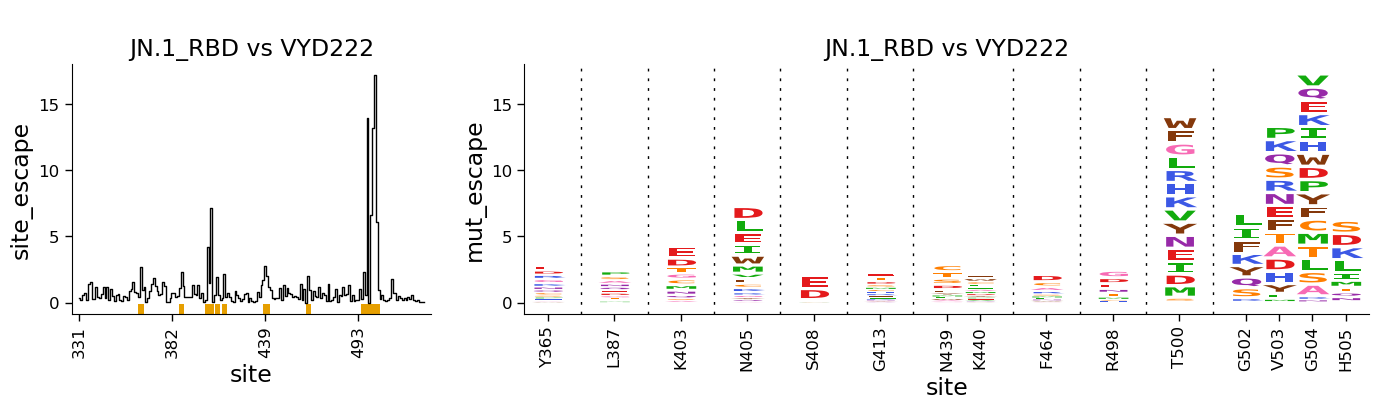

No data found for antibody='VYD222' vs antigen='XBB.1.5_RBD'


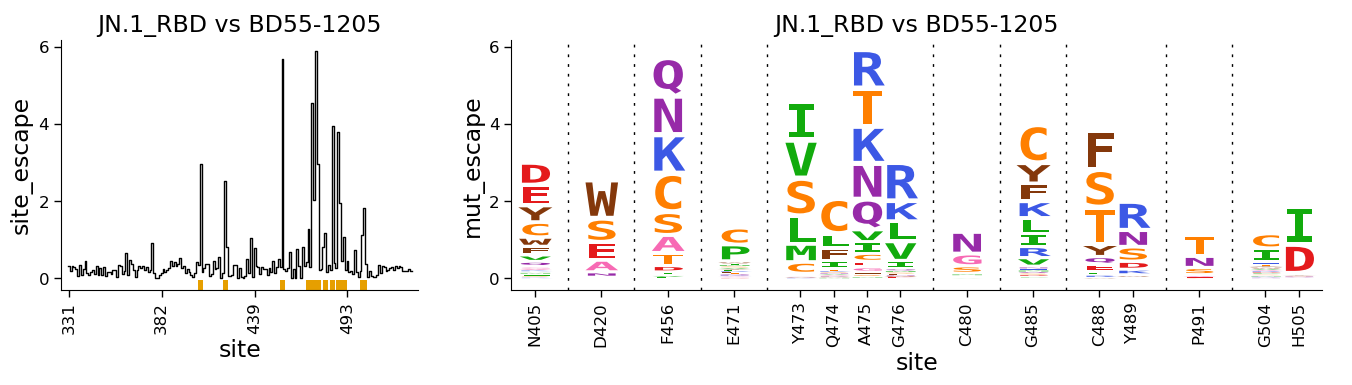

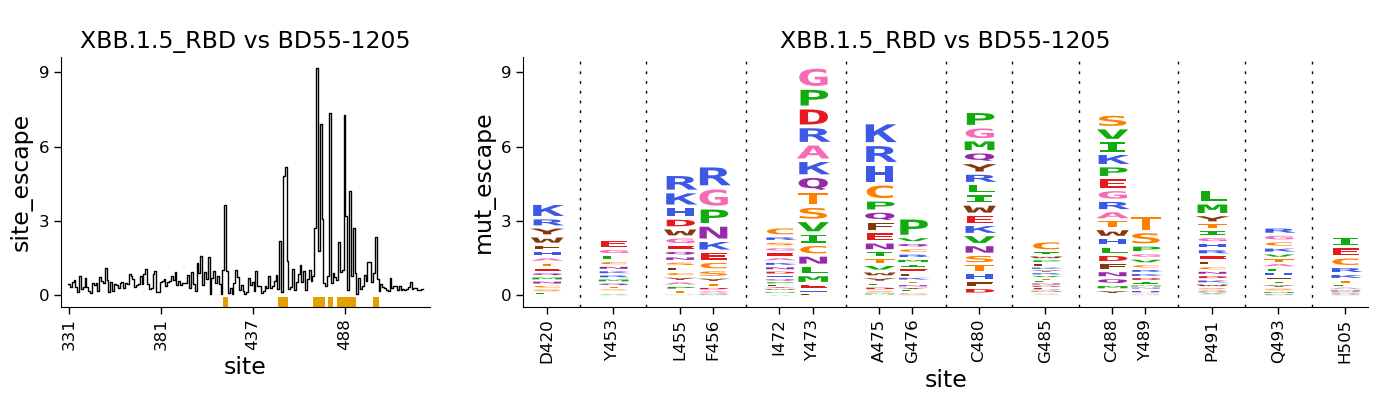

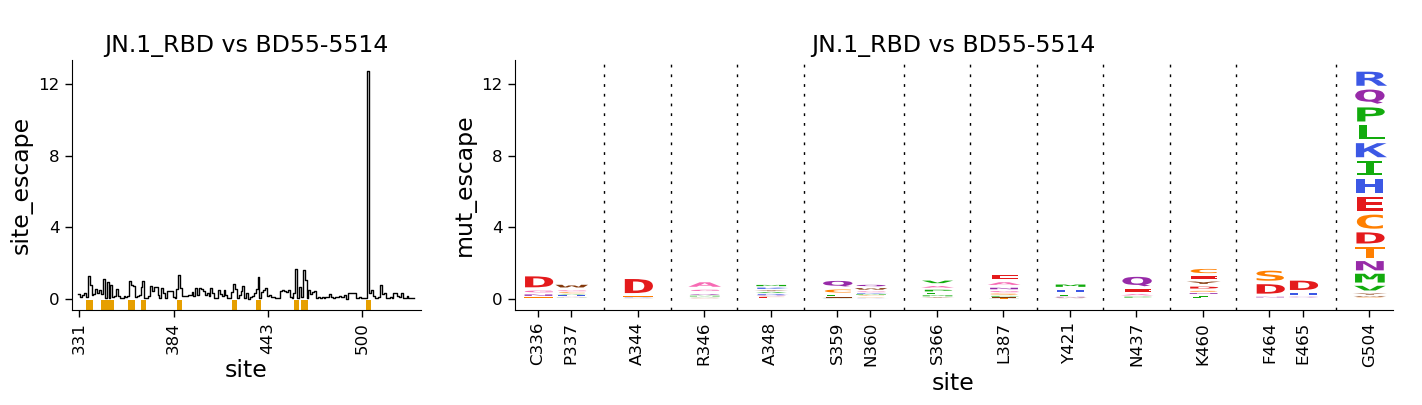

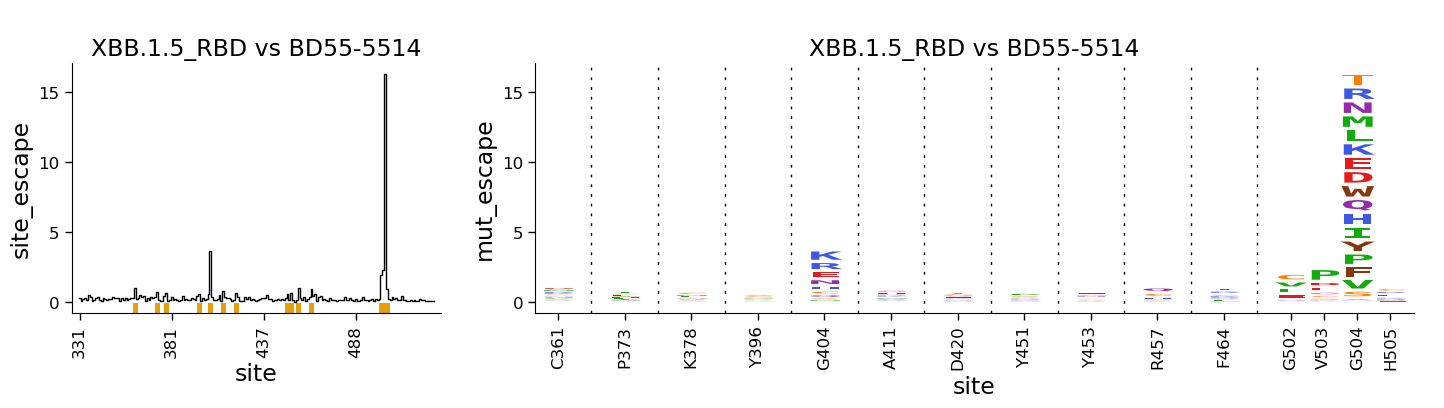

In [4]:
antibodies = set(df["antibody"])

antigens = sorted(df["antigen"].unique())

# antibodies to plot
antibodies_of_interest = ["VYD222", "BD55-1205", "BD55-5514"]

# plot the top this many sites for each antigen
top_n = 15

for antibody, antigen in itertools.product(antibodies_of_interest, antigens):
    if (
        (antibody not in antibodies_of_interest)
        or (antigen not in set(df.query("antibody == @antibody")["antigen"]))
    ):
        print(f"No data found for {antibody=} vs {antigen=}")
        continue
        
    # get data just for the antibody
    antibody_df = (
        df
        .query("antibody == @antibody")
        .query("antigen == @antigen")
        .assign(
            site_escape=lambda x: x.groupby(["site", "antigen"])["mut_escape"].transform("sum"),
            site_label=lambda x: x["wildtype"] + x["site"].astype(str),
        )
    )

    # add sequential sites
    antibody_df = antibody_df.merge(
        antibody_df[["site"]].drop_duplicates().reset_index(drop=True).reset_index(names="isite"),
    )
    
    # get the top sites
    top_sites = (
        antibody_df
        [["site", "site_escape", "antigen"]]
        .drop_duplicates()
        .sort_values("site_escape")
        .groupby("antigen")
        .tail(n=top_n)
        ["site"]
        .tolist()
    )
    antibody_df["show_site"] = antibody_df["site"].isin(top_sites)

    # make the plot with dmslogo: https://jbloomlab.github.io/dmslogo
    fig, axes = dmslogo.facet_plot(
        antibody_df,
        gridrow_col="antigen",
        x_col="isite",
        show_col="show_site",
        draw_line_kwargs={"height_col": "site_escape", "xtick_col": "site"},
        draw_logo_kwargs={
            "letter_col": "mutation",
            "letter_height_col": "mut_escape",
            "xtick_col": "site_label",
            "xlabel": "site",
        },
        share_ylim_across_rows=False,
        line_titlesuffix=f"vs {antibody}",
        logo_titlesuffix=f"vs {antibody}",
    )

    display(fig)
    plt.close(fig)